# Heterogeneous Treatment Effects and Python
## Agenda

- RCTにおけるHeterogeneous treatment Effectの推定
- `xgboost`を活用したHeterogeneous treatment Effect推定方法の確認


RCTの結果を分析する際、まずtreatment groupとcontrol groupのoutcome valueの平均を計算し比較することから始まる。この場合,Average Treatment Effect(ATE)を推定することができる。今回は、個々のunit of observation(観察単位)でtreatment effectが異なる場合に、どのようにcovariateとheterogeneous treatment effectを関連づけて推定するのか、その方法を紹介する。


### Python

In [1]:
!python -V

Python 3.7.4


### pip install

In [2]:
#!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes

### Import

In [3]:
import re

import pandas as pd
import numpy as np
import patsy
from sklearn import linear_model, ensemble, base, neural_network
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.iolib.summary2 import summary_col

import xgboost as xgb

## 1. Background and Data

Program Keluarga Harapan (PKH)というインドネシアで実施されたRCTから得られたデータを今回は用いる。PKHは児童の健康状態の改善を目的に妊娠した女性に対してcash transferを実施したプログラムである。

cash transferの受給資格は、

- the kecamatan (district) levelでランダムに給付対象を決定
- 実施が決まったkecamatanでは、全ての妊婦はプログラムへの参加を選択することができる

cash transferの給付条件は、

1. 産前に４回以上、産後に2回以上、調査員の訪問に立ち会うこと
2. iron supplements(鉄分のサプリメント)を摂取すること
3. 出産は医者かmidwifeの立ち合いの下、実施されること

cash transferの実施方法は

- 四半期毎に給付
- about 60-220 dollarsまたは四半期消費額の15-20%相当の金銭が給付される



In [4]:
# データの読み込み
url = "https://datascience.quantecon.org/assets/data/Triyana_2016_price_women_clean.csv.gz"
df = pd.read_csv(url)
df.head()

,rid_panel,prov,Location_ID,dist,wave,edu,agecat,log_xp_percap,rhr031,rhr032,...,hh_xp_all,tv,parabola,fridge,motorbike,car,pig,goat,cow,horse
0,3.411010e+12,35.0,3517150,353517,1,6,2,11.710995,1,1,...,2,1,0,0,0,0,0,0,0,0
1,NaN,32.0,3208021,323208,1,99,5,15.018967,1,1,...,5,1,1,1,1,1,1,1,1,1
2,3.571009e+12,35.0,3518120,353518,1,6,3,12.696151,1,0,...,5,0,0,0,0,0,0,0,1,0
3,2.131006e+12,35.0,3502100,353502,1,6,5,12.169301,0,1,...,3,1,0,0,0,0,0,1,0,0
4,3.071007e+12,35.0,3513130,353513,1,12,4,11.410970,0,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
df.describe()

,rid_panel,prov,Location_ID,dist,wave,edu,agecat,log_xp_percap,rhr031,rhr032,...,hh_xp_all,tv,parabola,fridge,motorbike,car,pig,goat,cow,horse
count,1.225100e+04,22768.000000,2.277100e+04,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,...,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.00000,22771.000000,22771.000000
mean,3.406884e+12,42.761156,4.286882e+06,431842.012033,1.847174,52.765799,4.043081,13.420404,0.675157,0.754908,...,3.839181,0.754908,0.482148,0.498661,0.594792,0.470511,0.536691,0.53858,0.515041,0.470247
std,1.944106e+12,14.241982,1.423541e+06,143917.353784,0.875323,45.833778,1.280589,1.534089,0.468326,0.430151,...,1.481982,0.430151,0.499692,0.500009,0.490943,0.499141,0.498663,0.49852,0.499785,0.499125
min,1.100103e+10,31.000000,3.175010e+06,3524.000000,1.000000,6.000000,0.000000,7.461401,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.731008e+12,32.000000,3.210180e+06,323210.000000,1.000000,6.000000,3.000000,11.972721,0.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,3.491004e+12,35.000000,3.517171e+06,353517.000000,2.000000,12.000000,5.000000,12.851639,1.000000,1.000000,...,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000
75%,5.061008e+12,53.000000,5.307020e+06,535307.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,6.681013e+12,75.000000,7.571030e+06,757571.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## 2. Potential Outcomes and Treatment Effects

まずATEの推定を行う。Outcomeはbirth weightとassited_delivery(医師の指導の下での出産)。

In [6]:
# some data prep for later
formula = """
bw ~ pkh_kec_ever +
  C(edu)*C(agecat) + log_xp_percap + hh_land + hh_home + C(dist) +
  hh_phone + hh_rf_tile + hh_rf_shingle + hh_rf_fiber +
  hh_wall_plaster + hh_wall_brick + hh_wall_wood + hh_wall_fiber +
  hh_fl_tile + hh_fl_plaster + hh_fl_wood + hh_fl_dirt +
  hh_water_pam + hh_water_mechwell + hh_water_well + hh_water_spring + hh_water_river +
  hh_waterhome +
  hh_toilet_own + hh_toilet_pub + hh_toilet_none +
  hh_waste_tank + hh_waste_hole + hh_waste_river + hh_waste_field +
  hh_kitchen +
  hh_cook_wood + hh_cook_kerosene + hh_cook_gas +
  tv + fridge + motorbike + car + goat + cow + horse
"""
bw, X = patsy.dmatrices(formula, df, return_type="dataframe", NA_action='drop')
# some categories are empty after dropping rows will Null, drop now
X = X.loc[:, X.sum() > 0]
bw = bw.iloc[:, 0]
treatment_variable = "pkh_kec_ever"
treatment = X["pkh_kec_ever"]
Xl = X.drop(["Intercept", "pkh_kec_ever", "C(dist)[T.313175]"], axis=1)
loc_id = df.loc[X.index, "Location_ID"].astype("category")


# remove [ ] from names for compatibility with xgboost
Xl = Xl.rename(columns=lambda x: re.sub('\[|\]','_',x))

In [7]:
tmp = pd.DataFrame(dict(birthweight=bw,treatment=treatment,assisted_delivery=df.loc[X.index, "good_assisted_delivery"]))
tmp.head()

,birthweight,treatment,assisted_delivery
0,3100.0,0.0,1.0
3,2800.0,0.0,1.0
4,3000.0,0.0,1.0
14,4400.0,0.0,1.0
15,3200.0,0.0,1.0


In [8]:
usage = smf.ols("assisted_delivery ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
health= smf.ols("bw ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
print(summary_col([usage, health]))


          assisted_delivery     bw   
-------------------------------------
Intercept 0.7827            3173.4067
          (0.0124)          (10.2323)
treatment 0.0235            -14.8992 
          (0.0192)          (24.6304)
R-squared 0.0002            -0.0001  
          0.0004            0.0001   
Standard errors in parentheses.


原文では

```
The program did increase the percent of births assisted by a medical professional, but on average, did not affect birth weight.
```

となっているが、一般的なt検定の観点からはbirth-weightに対してもassisted_deliveryに対しても影響を与えていると解釈することは難しいと思われる。

## 3. Generic ML Inference

Potential Outcome Frameworkにおける

$$
E[y_i(1) - y_i(0) |X_i=x]
$$

を推定することを考える。Conditional Average Treatment Effect(CATE)を推定するともいう。

### Best Linear Projection of CATE

True CATEの表記として$s_0(x) = E[y_i(1) - y_i(0) |X_i=x]$と定める。$S(x)$は$s_0(x)$の推定量とする。$S(x)$の推定量としての性能（goodness of fit）を測る指標として、

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\beta_0, \beta_1 = \argmin_{b_0,b_1} E[(s_0(x) -
b_0 - b_1 (S(x)-E[S(x)]))^2]
$$

が考えられる。$\beta_0, \beta_1$は$s_0(x)$を$S(x)$に線形射影した場合に得られるパラメーターである。解釈としては、

- $\beta_1 = 1$: 近似が完璧にうまくいっている, i.e., $s_0(x) = S(x)$
- $\beta_1 = 0$: $s_0(x)$は$S(x)$と無相関



### Grouped Average Treatment Effects

`Victor Chernozhukov, Mert Demirer, Esther Duflo, and Iván Fernández-Val. Generic machine learning inference on heterogenous treatment effects in randomized experiments`では$S(x)$をグループ毎で推定するという手法、GATEを紹介している。GATEとは、$S(x)$のvalueに応じてdataを分割し、グループを作り、Treatment Effectを推定する手法である（leakageについてはのちに言及）。

まず、

$$
G_{k}(x) = 1\{\ell_{k-1} \leq S(x) \leq \ell_k \}
$$

という変数を考える。$\ell_{k}$は分析者によって定められる定数であったり、$S(x)$のquantileなどが考えられる。このように分割されたグループに対して、

$$
\gamma_k = E[y(1) - y(0) | G_k(x)]
$$

を推定する。(1) $s_0(x)$がconstantではなく, and (2)$S(x)$が$s_0(x)$をうまく近似している、という２条件が揃った場合、$\gamma_k$はkとともに増加するはずである。

### Estimation

CATEとGATEの推定方法を紹介する。まず、$B(x) = \widehat{E[y(0)|x]}$としたとき、

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \beta_0 (d_i-P(d=1)) + \beta_1
(d_i-P(d=1))(S(x_i) - E[S(x_i)]) + \epsilon_i
$$

という推定式を考える。consistent estimatorの条件として$B(x), S(x)$が$y_i$と無相関である必要がある（方法論としては、sample-splitting、cross-validationを参照）。

GATEの推定式は、

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \sum_k \gamma_k (d_i-P(d=1)) 1(G_k(x_i)) +
u_i
$$

となる。

In [9]:
# for clustering standard errors
def get_treatment_se(fit, cluster_id, rows=None):
    if cluster_id is not None:
        if rows is None:
            rows = [True] * len(cluster_id)
        vcov = sm.stats.sandwich_covariance.cov_cluster(fit, cluster_id.loc[rows])
        return np.sqrt(np.diag(vcov))

    return fit.HC0_se

In [10]:
def generic_ml_model(x, y, treatment, model, n_split=10, n_group=5, cluster_id=None):
    """
    How it works
        using the cross-validation method
        partition the data using quantile, and the number of quantile is defined by n_groups
    
    INPUT
        x: covariate
        y: outcome
        model: ML prediction model
        n_split: 
        n_group: the number of the groups
    """
    nobs = x.shape[0]

    blp = np.zeros((n_split, 2))
    blp_se = blp.copy()
    gate = np.zeros((n_split, n_group))
    gate_se = gate.copy()

    baseline = np.zeros((nobs, n_split))
    cate = baseline.copy()
    lamb = np.zeros((n_split, 2))

    for i in range(n_split):
        main = np.random.rand(nobs) > 0.5 #uniform distribution with the support (0,1)
        rows1 = ~main & (treatment == 1)
        rows0 = ~main & (treatment == 0)

        mod1 = base.clone(model).fit(x.loc[rows1, :], (y.loc[rows1])) #Constructs a new estimator with the same parameters.
        mod0 = base.clone(model).fit(x.loc[rows0, :], (y.loc[rows0]))
        
        B = mod0.predict(x) 
        S = mod1.predict(x) - B 
        baseline[:, i] = B
        cate[:, i] = S
        ES = S.mean()

        ## BLP
        # assume P(treat|x) = P(treat) = mean(treat)
        p = treatment.mean()
        reg_df = pd.DataFrame(dict(
            y=y, B=B, treatment=treatment, S=S, main=main, excess_S=S-ES
        ))
        reg = smf.ols("y ~ B + I(treatment-p) + I((treatment-p)*(S-ES))", 
                      data=reg_df.loc[main, :]) # remove index of the learning data, and set the interaction terms
        reg_fit = reg.fit()
        blp[i, :] = reg_fit.params.iloc[2:4] # get the params of I(treatment-p) and I((treatment-p)*(S-ES))
        blp_se[i, :] = get_treatment_se(reg_fit, cluster_id, main)[2:]

        lamb[i, 0] = reg_fit.params.iloc[-1]**2 * S.var()

        ## GATEs
        cutoffs = np.quantile(S, np.linspace(0,1, n_group + 1))
        cutoffs[-1] += 1
        for k in range(n_group):
            reg_df[f"G{k}"] = (cutoffs[k] <= S) & (S < cutoffs[k+1])

        g_form = "y ~ B + " + " + ".join([f"I((treatment-p)*G{k})" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=reg_df.loc[main, :])
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.values[2:] #g_fit.params.filter(regex="G").values
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, main)[2:]

        lamb[i, 1] = (gate[i,:]**2).sum()/n_group

    out = dict(
        gate=gate, gate_se=gate_se,
        blp=blp, blp_se=blp_se,
        Lambda=lamb, baseline=baseline, cate=cate,
        name=type(model).__name__
    )
    return out


def generic_ml_summary(generic_ml_output):
    out = {
        x: np.nanmedian(generic_ml_output[x], axis=0)
        for x in ["blp", "blp_se", "gate", "gate_se", "Lambda"]
    }
    out["name"] = generic_ml_output["name"]
    return out

In [11]:
@ignore_warnings(category=ConvergenceWarning)
def evaluate_models(models, y, **other_kw):
    all_kw = kw.copy()
    all_kw["y"] = y
    all_kw.update(other_kw)
    return list(map(lambda x: generic_ml_model(model=x, **all_kw), models))

In [12]:
def generate_report(results):
    summaries = list(map(generic_ml_summary, results))
    df_plot = pd.DataFrame({
        mod["name"]: np.median(mod["cate"], axis=1)
        for mod in results
    })

    print("Correlation in median CATE:")
    display(df_plot.corr())
    sns.pairplot(df_plot, diag_kind="kde", kind="reg")

    print("\n\nBest linear projection of CATE")
    df_cate = pd.concat({
        s["name"]: pd.DataFrame(dict(blp=s["blp"], se=s["blp_se"]))
        for s in summaries
    }).T.stack()
    display(df_cate)

    print("\n\nGroup average treatment effects:")
    df_groups = pd.concat({
        s["name"]: pd.DataFrame(dict(gate=s["gate"], se=s["gate_se"]))
        for s in summaries
    }).T.stack()
    display(df_groups)

#### ML modelの定式化

In [13]:
models = [
    linear_model.LassoCV(cv=10, n_alphas=25, max_iter=500, tol=1e-4, n_jobs=1),
    ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=20),
    xgb.XGBRegressor(n_estimators=200, max_depth=3, reg_lambda=2.0, reg_alpha=0.0, objective="reg:squarederror"),
    neural_network.MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=500, activation="logistic",
                                solver="adam", tol=1e-3, early_stopping=True, alpha=0.0001)
]

#### Dataの作成

In [14]:
## Generating data 
kw = dict(x=Xl, treatment=treatment, n_split=11, n_group=5, cluster_id=loc_id)

#### Estimation in practice

In [15]:
results = evaluate_models(models, y=bw)

Correlation in median CATE:


,LassoCV,RandomForestRegressor,XGBRegressor,MLPRegressor
LassoCV,1.000000,0.448470,0.199991,-0.289852
RandomForestRegressor,0.448470,1.000000,0.500658,-0.109373
XGBRegressor,0.199991,0.500658,1.000000,-0.083662
MLPRegressor,-0.289852,-0.109373,-0.083662,1.000000




Best linear projection of CATE


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
blp 0  -6.194234             -21.357093    -22.585157    -11.535369
    1  -0.142745              -0.050744      0.130698  -1342.137434
se  0  32.501594              32.210025     32.290930     33.135922
    1   0.533906               0.257139      0.081847   2656.055504



Group average treatment effects:


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
gate 0  12.220149              17.208108    -51.844425    -35.979122
     1   0.000000             -26.622054    -27.469597     31.301906
     2   0.000000             -57.951111    -11.570107    -25.787032
     3   0.000000             -16.227565     13.591713    -48.288432
     4 -23.773770             -15.132455     58.484636     -9.478328
se   0  56.170311              65.568245     65.187190     79.212914
     1  63.676245              71.500461     66.515545     74.151347
     2  64.777781              68.035798     62.795372     66.648060
     3  57.985263              69.443319     69.083398     64.082168
     4  64.144903              71.499470     72.452223     66.407152

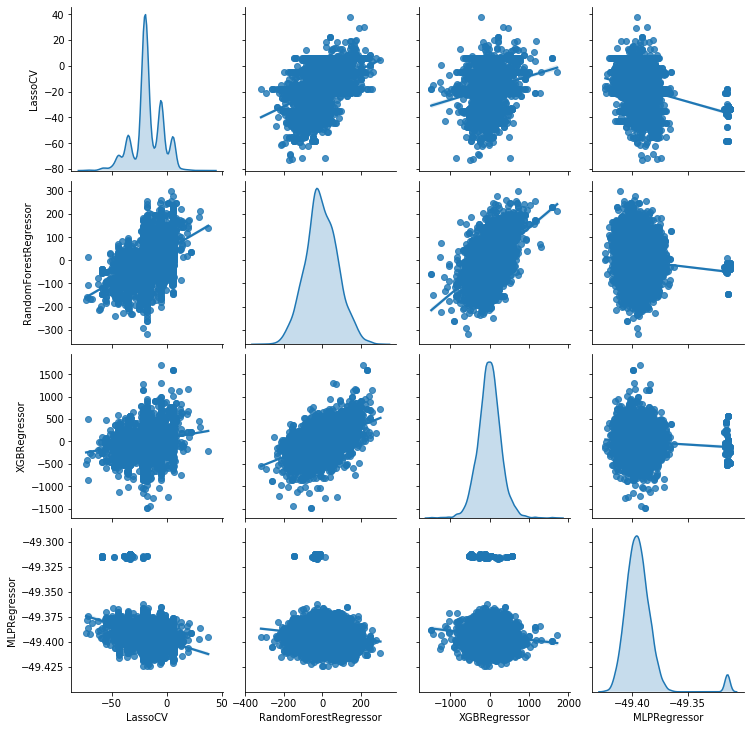

In [16]:
generate_report(results)

分析結果の解釈は上から二つ目のTableを参照すれば良い。モデルによって、パラメターが異なり、またCATEはstatistically insignificantという結果になって居る。これはMLモデルの精度がよくない、またはCATEがそもそも0のいずれかに起因すると考えられる。

### Assisted Delivery

Outcome variableを変更して実施してみる。

In [17]:
ad = df.loc[X.index, "good_assisted_delivery"]#"midwife_birth"]
results_ad = evaluate_models(models, y=ad)

Correlation in median CATE:


,LassoCV,RandomForestRegressor,XGBRegressor,MLPRegressor
LassoCV,1.000000,0.854176,0.526326,0.812225
RandomForestRegressor,0.854176,1.000000,0.573571,0.675573
XGBRegressor,0.526326,0.573571,1.000000,0.456229
MLPRegressor,0.812225,0.675573,0.456229,1.000000




Best linear projection of CATE


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
blp 0  0.051907               0.038326      0.038420      0.027793
    1  0.483117               0.448295      0.132133      0.413283
se  0  0.020371               0.022149      0.022061      0.021685
    1  0.141822               0.146848      0.077010      0.171295



Group average treatment effects:


LassoCV  RandomForestRegressor  XGBRegressor  MLPRegressor
gate 0 -0.039915              -0.067658     -0.030933     -0.026151
     1 -0.004218              -0.003400      0.015110      0.000166
     2  0.008669              -0.011214      0.028213     -0.010807
     3  0.094080               0.067568      0.029197      0.044088
     4  0.202870               0.187173      0.121073      0.139768
se   0  0.039347               0.050962      0.049136      0.039604
     1  0.042599               0.044791      0.041528      0.044564
     2  0.043820               0.043248      0.044194      0.046696
     3  0.046075               0.047092      0.045323      0.047819
     4  0.052104               0.054600      0.050299      0.056519

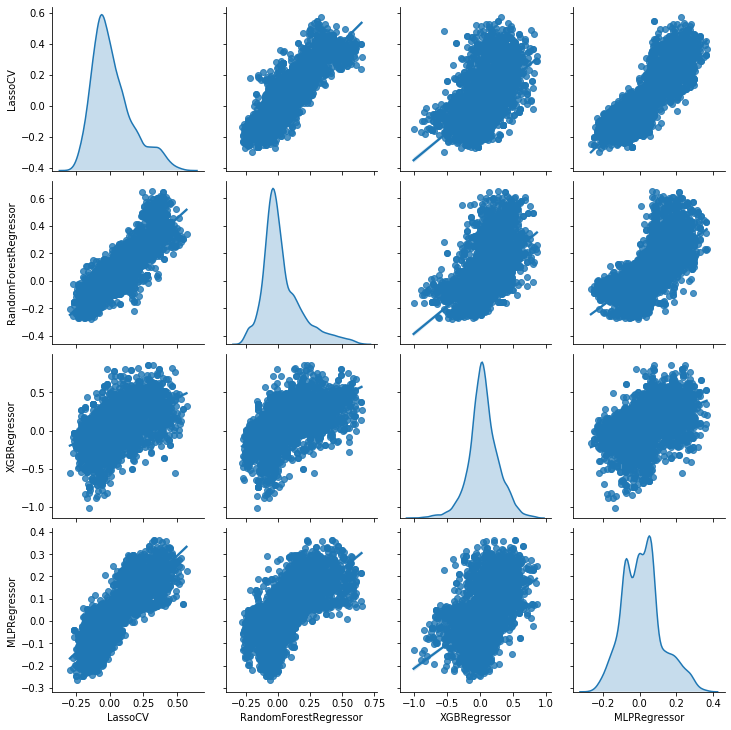

In [18]:
generate_report(results_ad)

## 4. Covariate Means by Group

Assited deliveryに対してCATEが存在すると解釈できるので、covariateに応じてどのようにCATEが変化するのか確認する。

In [19]:
def cov_mean_by_group(y, res, cluster_id):
    n_group = res["gate"].shape[1]
    gate = res["gate"].copy()
    gate_se = gate.copy()
    dat = y.to_frame()

    for i in range(res["cate"].shape[1]):
        S = res["cate"][:, i]
        cutoffs = np.quantile(S, np.linspace(0, 1, n_group+1))
        cutoffs[-1] += 1
        for k in range(n_group):
            dat[f"G{k}"] = ((cutoffs[k] <= S) & (S < cutoffs[k+1])) * 1.0

        g_form = "y ~ -1 + " + " + ".join([f"G{k}" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=dat.astype(float))
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.filter(regex="G").values
        rows = ~y.isna()
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, rows)

    out = pd.DataFrame(dict(
        mean=np.nanmedian(gate, axis=0),
        se=np.nanmedian(gate_se, axis=0),
        group=list(range(n_group))
    ))

    return out

In [20]:
def compute_group_means_for_results(results):
    to_cat = []
    for res in results:
        for v in variables:
            to_cat.append(
                cov_mean_by_group(df2[v], res, loc_id)
                .assign(method=res["name"], variable=v)
            )

    group_means = pd.concat(to_cat, ignore_index=True)
    group_means["plus2sd"] = group_means.eval("mean + 1.96*se")
    group_means["minus2sd"] = group_means.eval("mean - 1.96*se")
    return group_means

In [21]:
df2 = df.loc[X.index, :]
df2["edu99"] = df2.edu == 99
df2["educ"] = df2["edu"]
df2.loc[df2["edu99"], "educ"] = np.nan

variables = [
    "log_xp_percap","agecat","educ","tv","goat",
    "cow","motorbike","hh_cook_wood","pkh_ever"
]

In [22]:
group_means_ad = compute_group_means_for_results(results_ad)

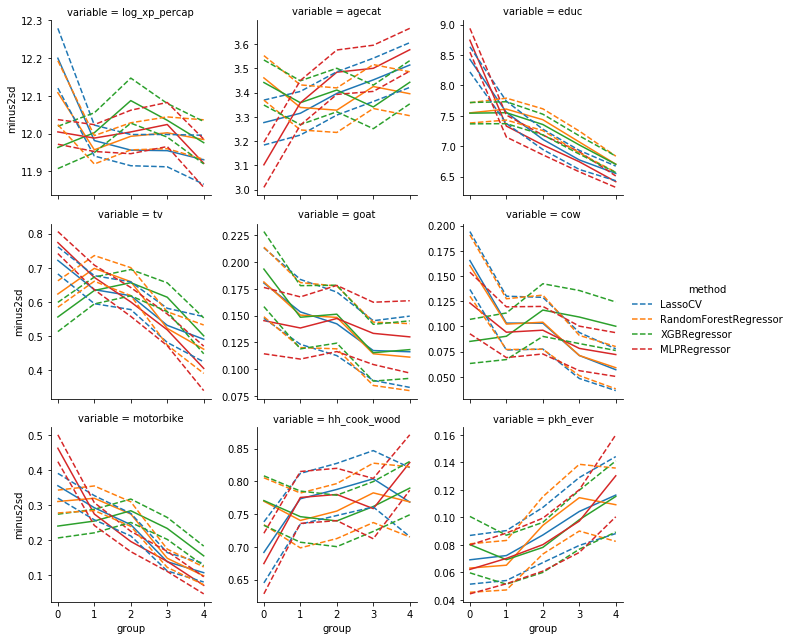

In [23]:
g = sns.FacetGrid(group_means_ad, col="variable", col_wrap=3, hue="method", sharey=False)
g.map(plt.plot, "group", "mean")
g.map(plt.plot, "group", "plus2sd", ls="--")
g.map(plt.plot, "group", "minus2sd", ls="--")
g.add_legend();